# Bulldozers Price Prediction

In this notebook, we will elaborate a machine learning project with the goal of predicting the sale price of bulldozers. This problem was posed in a Kaggle Competition, you can check the details here: https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview

## Problem definition
> How well can we predict the future price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers were sold for.

## Data
We will use the data downloaded from Kaggle. The data is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012.

## Evaluation
The evaluation metric we will be using is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

## Features
The key features are:
* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* Saleprice: what the machine sold for at auction (only provided in train.csv)
* Saledate: the date of the sale

The complete list containing 53 features can be viewed in the Data Dictionary.xls file.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [4]:
#Import training and validation sets
df = pd.read_csv("TrainAndValid.csv", parse_dates = ["saledate"], low_memory = False)

## Data Exploration

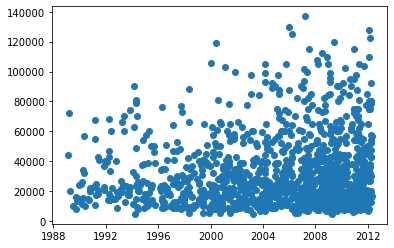

In [5]:
#We will take a random sample to plot.
np.random.seed(42)
sample = df.sample(frac=0.003)

fig, ax = plt.subplots()
ax.scatter(sample["saledate"], sample["SalePrice"]);

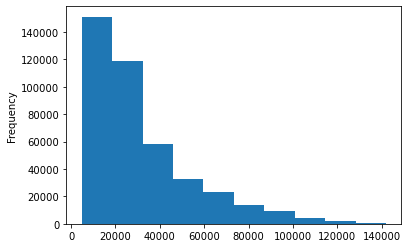

In [6]:
df.SalePrice.plot.hist();

In [7]:
df.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## Enriching features: adding datetime parameters for saledate column

In [8]:
#Make a copy to edit
df_tmp = df.copy()

#Enrich the features
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear


In [9]:
#Now we are gonna remove the saledate column
df_tmp.drop("saledate", axis = 1, inplace=True)

## Dealing with non-numerical features

In [10]:
#We will use pandas Categories to threat the strings as categories
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

#Note that the data doesn't appear to change
df_tmp.T

#But if you ask...
df_tmp.state.cat.codes

0          0
1         32
2         31
3         43
4         31
          ..
412693    43
412694     8
412695     8
412696    43
412697     8
Length: 412698, dtype: int8

## Dealing with missing values

In [11]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Numerical values

In [12]:
#Looking for the numerical features with missing values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label + ": " +str(df_tmp[label].isna().sum()))

auctioneerID: 20136
MachineHoursCurrentMeter: 265194


In [13]:
# Fill numerical missing values with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #Add a binary column which tells us if the data was missing in the beginning (we don't wanna lose this info)
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            df_tmp[label] = content.fillna(content.median())

### Categorical variables

In [14]:
#We will turn categorical variables into numbers and fill missing values
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        #Add binary column to identify missing values
        df_tmp[label + "_is_missing"] = pd.isnull(content)
        #Update the categoric values with the code given by pandas categories
        df_tmp[label] = pd.Categorical(content).codes+1
        #Pandas categories turn missing values in -1. We add 1 so these cells will turn into 0.

In [15]:
df_tmp.isna().sum()
df_tmp.isna().sum().sum()

0

In [18]:
df_tmp.T

,0,1,2,3,4,5,6,7,8,9,...,412688,412689,412690,412691,412692,412693,412694,412695,412696,412697
SalesID,1139246,1139248,1139249,1139251,1139253,1139255,1139256,1139261,1139272,1139275,...,6333305,6333314,6333330,6333339,6333343,6333344,6333345,6333347,6333348,6333349
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0,26500.0,21000.0,27000.0,21500.0,65000.0,...,11500.0,13000.0,20500.0,13000.0,10000.0,10000.0,10500.0,12500.0,10000.0,13000.0
MachineID,999089,117657,434808,1026470,1057373,1001274,772701,902002,1036251,1016474,...,1800259,1908162,1879923,1856845,1799614,1919201,1882122,1944213,1794518,1944743
ModelID,3157,77,7009,332,17311,4605,1937,3539,36003,3883,...,21437,21437,21446,21435,21435,21435,21436,21435,21435,21436
datasource,121,121,121,121,121,121,121,121,121,121,...,149,149,149,149,149,149,149,149,149,149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Backhoe_Mounting_is_missing,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Blade_Type_is_missing,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Travel_Controls_is_missing,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Differential_Type_is_missing,False,False,True,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True


## Splitting the data
Ps: We are using the archive "TrainAndValid.csv" because we want to exercise splitting the data. Following the instructions of the project, we will use the data of sales before 2012 to train, and the ones of 2012 to validate. Naturally, we could use the "Train.csv" file to train and the "Valid.csv" file to validate our model, what would lead to the same result.

In [19]:
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear!= 2012]

In [20]:
X_train, Y_train = df_train.drop("SalePrice", axis = 1), df_train.SalePrice
X_valid, Y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

## Modeling

In [21]:
%%time
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs = -1, random_state=42)
model.fit(X_train, Y_train)

CPU times: user 10min 39s, sys: 4.84 s, total: 10min 44s
Wall time: 1min 34s


RandomForestRegressor(n_jobs=-1, random_state=42)

## Score

In [113]:
#Create evaluation function: RMSLE metric
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def RMSLE(Y_test, Y_preds):
    """
    Calculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(Y_test, Y_preds))

#Create function to evaluate model on a more levels (not asked in the competition)
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(Y_train, train_preds),
             "Valid MAE": mean_absolute_error(Y_valid, val_preds),
              "Training RMSLE": RMSLE(Y_train, train_preds),
              "Valid RMSLE": RMSLE(Y_valid, val_preds),
              "Training R^2": r2_score(Y_train, train_preds),
              "Valid R^2":r2_score(Y_valid, val_preds)
             }
    return scores

In [114]:
show_scores(model)

{'Training MAE': 1578.452360361484,
 'Valid MAE': 6125.117301477577,
 'Training RMSLE': 0.0841335910166914,
 'Valid RMSLE': 0.2546446969689846,
 'Training R^2': 0.9875229075349308,
 'Valid R^2': 0.8724699827023497}

## Tunning Hyperparameters
Since our model takes a considerable time to train, we will be training in a small sample in order to tune the hyperparameters. The final model, however, will be trained in the whole dataset.

In [115]:
%%time
from sklearn.ensemble import RandomForestRegressor
#We will set each estimator to be built in only 10.000 samples
model = RandomForestRegressor(n_jobs = -1, random_state=42, max_samples=10000)
model.fit(X_train, Y_train)

CPU times: user 26.5 s, sys: 678 ms, total: 27.2 s
Wall time: 6.24 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [116]:
show_scores(model) #Still not bad

{'Training MAE': 5554.061618822063,
 'Valid MAE': 7139.615822172297,
 'Training RMSLE': 0.25758465681614984,
 'Valid RMSLE': 0.29248380187626777,
 'Training R^2': 0.8608402371243158,
 'Valid R^2': 0.83308596217853}

### Tunning with RandomizedSearchCV

In [117]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split":np.arange(2,20,2),
    "min_samples_leaf":np.arange(1,20,2),
    "max_features":[0.5, 1, "sqrt", "auto"],
    "max_samples":[10000]
}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                             param_distributions = rf_grid,
                             n_iter=2,
                             cv=5,
                             verbose = True)
rs_model.fit(X_train, Y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 26.4 s, sys: 2.51 s, total: 28.9 s
Wall time: 37 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [118]:
#Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 4,
 'min_samples_leaf': 19,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': None}

## Train a model with best hyperparameters
**Note:** This was found after set n_iter = 100 in `RandomizedSearchCV`


In [119]:
%%time
#Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40, 
                                    min_samples_leaf=1, 
                                    min_samples_split=14, 
                                    max_features=0.5, 
                                    n_jobs=-1, 
                                    max_samples=None,
                                   random_state=42)
ideal_model.fit(X_train, Y_train)

CPU times: user 1min 44s, sys: 860 ms, total: 1min 45s
Wall time: 16.6 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [120]:
show_scores(ideal_model)

{'Training MAE': 2951.123355082265,
 'Valid MAE': 5966.934781951541,
 'Training RMSLE': 0.144427431435229,
 'Valid RMSLE': 0.246251621813037,
 'Training R^2': 0.9589090179371786,
 'Valid R^2': 0.8819835895768973}

## Make predictions on test data

In [129]:
df_test = pd.read_csv("Test.csv", low_memory=False, parse_dates=["saledate"])
df_test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,NaN,NaN,2012-10-24,80NX3,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
12453,6643173,2558332,21434,149,2,2005,NaN,NaN,2012-10-24,28N,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
12454,6643184,2558342,21437,149,2,1000,NaN,NaN,2012-10-24,35N,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
12455,6643186,2558343,21437,149,2,2006,NaN,NaN,2012-10-24,35N,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


### Preprocessing the data
We have missing values, strings, etc.. in our test set. Let's put it in a format that our model accept.

In [130]:
def preprocess_data(df_tmp):
    """
    Performs transformations on df and returns transformed df
    """
    #Enrich features 
    df_tmp["saleYear"] = df_tmp.saledate.dt.year
    df_tmp["saleMonth"] = df_tmp.saledate.dt.month
    df_tmp["saleDay"] = df_tmp.saledate.dt.day
    df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
    df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

    df_tmp.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df_tmp.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                #Add a binary column which tells us if the data was missing in the beginning (we don't wanna lose this info)
                df_tmp[label + "_is_missing"] = pd.isnull(content)
                df_tmp[label] = content.fillna(content.median())
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            df_tmp[label] = pd.Categorical(content).codes+1
        
    return df_tmp

In [131]:
# Process the test data
df_test= preprocess_data(df_test)

In [132]:
df_test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True


In [133]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1139246,999089,3157,121,3.0,2004,68.0,2,963,298,...,True,True,True,True,True,True,True,True,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,2,1745,529,...,True,True,True,True,True,True,True,True,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,336,111,...,True,True,True,True,True,True,True,True,True,True
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3716,1381,...,True,True,True,True,True,True,True,True,True,True
4,1139253,1057373,17311,121,3.0,2007,722.0,3,4261,1538,...,True,True,True,True,True,True,True,True,True,True


In [134]:
#We have different shapes probably because some category had no missing values in the test data.
set(X_train.columns)-set(df_test.columns)

{'auctioneerID_is_missing'}

In [135]:
#Let's manually create and fill a auctioneerID_is_missing column
df_test["auctioneerID_is_missing"]=False
df_test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,True,True,True,True,True,False
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,True,True,True,True,True,False
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,True,True,True,True,True,False
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,True,True,True,True,True,False


### Making predictions

In [136]:
test_preds = ideal_model.predict(df_test)

/Users/lucianorenato/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Now we need to put the prediction in the format asked for kaggle. See https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation

In [138]:
df_preds = pd.DataFrame()
df_preds["SalesID"]=df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,20962.487692
1,1227844,19827.355039
2,1227847,50104.989473
3,1227848,66376.658700
4,1227863,45999.360583
...,...,...
12452,6643171,45330.723460
12453,6643173,16182.342102
12454,6643184,17066.325639
12455,6643186,22990.156396


## Export the data

In [139]:
df_preds.to_csv("test_predictions.csv", index=False)

## Feature Importance

In [140]:
ideal_model.feature_importances_

array([3.34924470e-02, 1.64748353e-02, 4.47004352e-02, 1.69028377e-03,
       3.28858493e-03, 2.02782264e-01, 3.13875078e-03, 9.83191106e-04,
       4.15237625e-02, 4.07149610e-02, 6.61902591e-02, 5.09205417e-03,
       1.78327762e-02, 1.49841216e-01, 4.75075898e-02, 5.96117040e-03,
       2.83186429e-03, 4.15283561e-03, 3.46774099e-03, 6.85760750e-02,
       6.46055813e-04, 8.22926053e-05, 7.84347964e-04, 2.50278281e-04,
       1.07596596e-03, 3.10663583e-04, 2.81785595e-03, 8.33504813e-03,
       8.27324018e-04, 2.31225006e-03, 3.67230453e-03, 8.23599337e-04,
       4.55895657e-03, 3.28528090e-04, 4.40520420e-03, 6.38225129e-03,
       8.20417927e-04, 1.21731513e-02, 2.59122437e-03, 2.22091122e-03,
       1.77194684e-03, 9.70894732e-04, 3.71483557e-03, 6.29108698e-04,
       4.29867961e-04, 3.51248285e-04, 6.65265644e-04, 1.64121118e-03,
       1.20260513e-03, 2.31213148e-04, 3.35331494e-04, 7.34100766e-02,
       3.76162877e-03, 5.65047051e-03, 2.90594983e-03, 9.92965774e-03,
      

In [156]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances}).sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    #Plot the dataframe
    fig, ax=plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

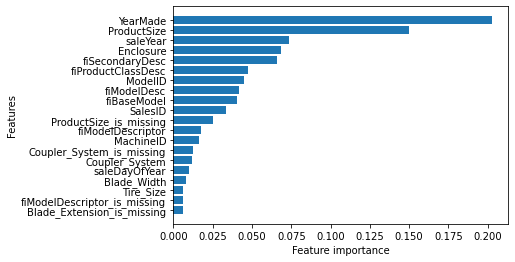

In [157]:
plot_features(X_train.columns, ideal_model.feature_importances_)